### 2 in the tilte means it is based on the simulated dataset

In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
    CompoundNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
lambda_ = Parameter("lambda_", value=1/60)

dataset_input = Dataset_load.create_asimov(
    model="ecpl", source="PKSflare", parameters=Parameters([scaled_amplitude, lambda_])
)
source_model = dataset_input.models[0].copy()

emask = dataset_input.mask.data.sum(axis=2).sum(axis=1)>0
energy = dataset_input.geoms['geom'].axes[0].center[emask]

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1160: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


(<WCSAxes: >,
 <Axes: xlabel='Energy [TeV]', ylabel='Residuals ((data - model) / sqrt(model))'>)

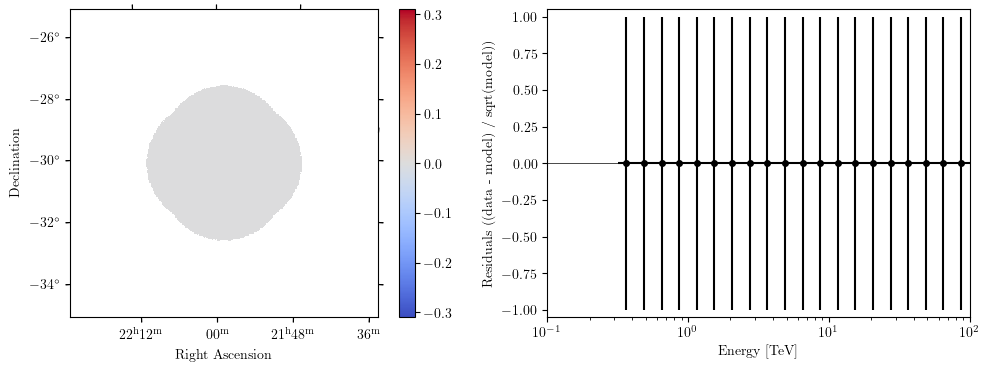

In [4]:
dataset_input.plot_residuals(kwargs_spatial={'vmax':0.31,
                                      'vmin':-0.31},
                      kwargs_spectral={'method' : 'diff/sqrt(model)'})

## Drawing artificial correlated background systematic

In [5]:
from scipy.stats import norm
sys_percentage = np.array([10] * 24)
l = len(sys_percentage)

print(l)


24


0.10000000000100001


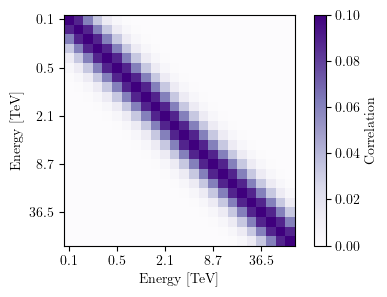

In [6]:
scale = 2
cov = np.ones((l,l)) * 1e-12
cov = np.identity(l)

# note: values set arbitrarily 
for i in range(l):
    if sys_percentage[i] > 0:
        gau = norm.pdf(range(l) , loc = i , scale = scale )
        cov[i,:] = gau / np.max(gau) * sys_percentage[i] / 100 
        cov[i,:] += [1e-12] * (l)
fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(cov, vmin = 0, vmax = 0.1,
               cmap = "Purples")
fig.colorbar(pos, ax=ax1)
print(cov.max())
ticks = [0,5,10,15,20]
energy_ticks = dataset_input.geoms['geom'].axes[0].center[ticks].value
energy_ticks = np.round(energy_ticks,1)
ax1.set_xticks(ticks)
ax1.set_xticklabels(energy_ticks)
ax1.set_yticks(ticks)
ax1.set_yticklabels(energy_ticks)
ax1.set_ylabel("Energy [TeV]")
ax1.set_xlabel("Energy [TeV]")
cbar = plt.gca().images[-1].colorbar
cbar.set_label('Correlation', rotation=90)

fig.savefig("plots/2_cov_matrix.pdf", bbox_inches="tight")
fig.savefig("plots/2_cov_matrix.png", bbox_inches="tight")



[-0.08622681 -0.1        -0.05220851  0.00975721  0.03525033  0.02363907
 -0.00404985 -0.03431816 -0.06218887 -0.0820296  -0.08383238 -0.06647851
 -0.04533962 -0.03048623 -0.01711631  0.00278771  0.02742634  0.0259036
 -0.01682383 -0.05090777 -0.04009575 -0.01717102 -0.00818003  0.00880092]


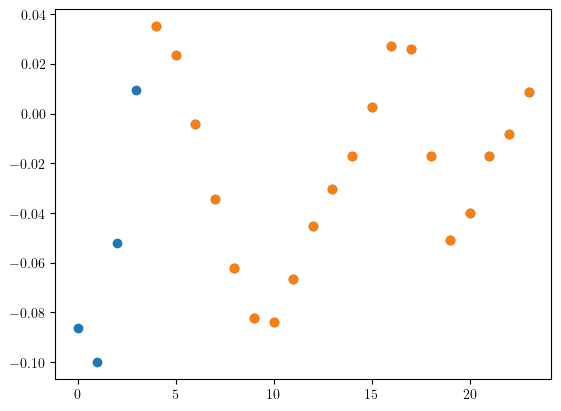

In [7]:
import numpy as np

# Define the mean and covariance matrix
mean = np.zeros(24)
#cov = np.eye(24)
sigma = 0.1
#cov = np.eye(24) + sigma * (1 - np.eye(24))
# Generate the correlated values

np.random.seed(38)
values = np.random.multivariate_normal(mean, cov, size=1, )[0]

# Scale the values to be between -0.1 and 0.1
values = values / np.max(np.abs(values)) * 0.1

print(values)
plt.scatter(range(24), values)
plt.scatter(np.arange(24)[emask], values[emask])

## Adding the systematic to the datasets

In [8]:

piecewisebkgmodel = FoVBackgroundModel(spectral_model = PiecewiseNormSpectralModel(
                                                        energy = dataset_input.geoms['geom'].axes[0].center),
                                      dataset_name=dataset_input.name)
dataset_input.models = Models([source_model, piecewisebkgmodel])
with dataset_input.models.parameters.restore_status():
    for n , v in zip(dataset_input.models[1].parameters[emask], values[emask]):
        n.value = 1+v
    print(dataset_input.models)
    dataset_input.counts = dataset_input.npred()


DatasetModels

Component 0: SkyModel

  Name                      : oXLdAvKg
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.017   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : i-u5Q_ih-bkg
  Datasets names            : ['i-u5Q_ih']
  Spectral model type       : PiecewiseNormSpectralModel
  Spatial  model type       : 
  Parameters:
    nor

In [9]:
print(dataset_input.models)

DatasetModels

Component 0: SkyModel

  Name                      : oXLdAvKg
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.017   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : i-u5Q_ih-bkg
  Datasets names            : ['i-u5Q_ih']
  Spectral model type       : PiecewiseNormSpectralModel
  Spatial  model type       : 
  Parameters:
    nor

(<WCSAxes: >, <Axes: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

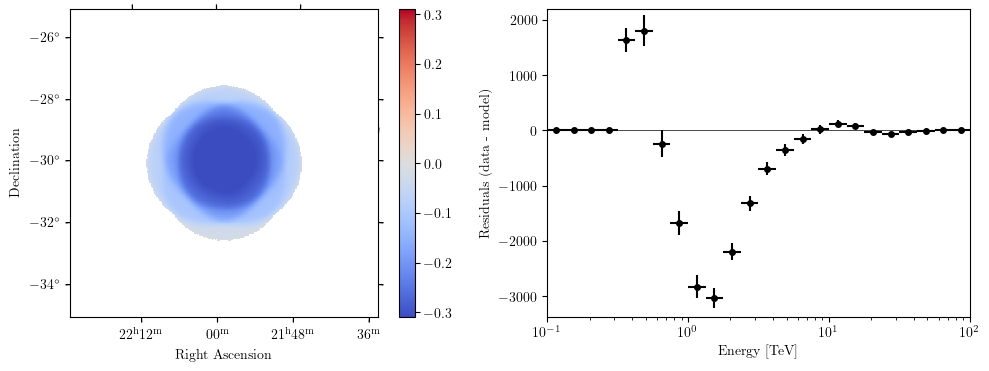

In [10]:
dataset_input.plot_residuals(kwargs_spatial={'vmax':0.31,
                                      'vmin':-0.31},
                      kwargs_spectral={'method' : 'diff'})

In [11]:
dataset_asimov = dataset_input.copy()
dataset_asimov.models =  Models([source_model.copy(), 
                                 FoVBackgroundModel(dataset_name=dataset_asimov.name)])
dataset_asimov.models.parameters['tilt'].frozen = False
print(dataset_asimov.models)

DatasetModels

Component 0: SkyModel

  Name                      : 08ee7Mro
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.017   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : UbD1-heQ-bkg
  Datasets names            : ['UbD1-heQ']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm

In [12]:
%%time
fit = Fit()
fit.run(dataset_asimov)

CPU times: user 16.8 s, sys: 4.32 s, total: 21.1 s
Wall time: 21.2 s


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 198
	total stat : 841827.01

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

In [13]:
print(dataset_asimov.models)

DatasetModels

Component 0: SkyModel

  Name                      : 08ee7Mro
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.325   +/-    0.07             
    amplitude                     :   9.80e-13   +/- 5.3e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.010   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : UbD1-heQ-bkg
  Datasets names            : ['UbD1-heQ']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm

(<WCSAxes: >, <Axes: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

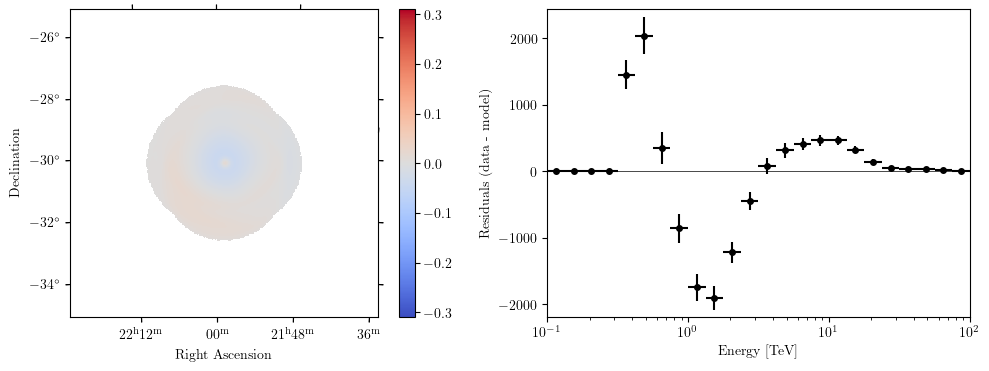

In [14]:
dataset_asimov.plot_residuals(kwargs_spatial={'vmax':0.31,
                                      'vmin':-0.31},
                      kwargs_spectral={'method' : 'diff'})

In [15]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6, color = 'red'):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label, color = color)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            try:
                plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                    fmt = fmts[j],
                    markersize = markersize[j], 
                        color = colors [j])
            except:
                pass

    plt.tight_layout()
    return fig

markersize = [6,10, 10]

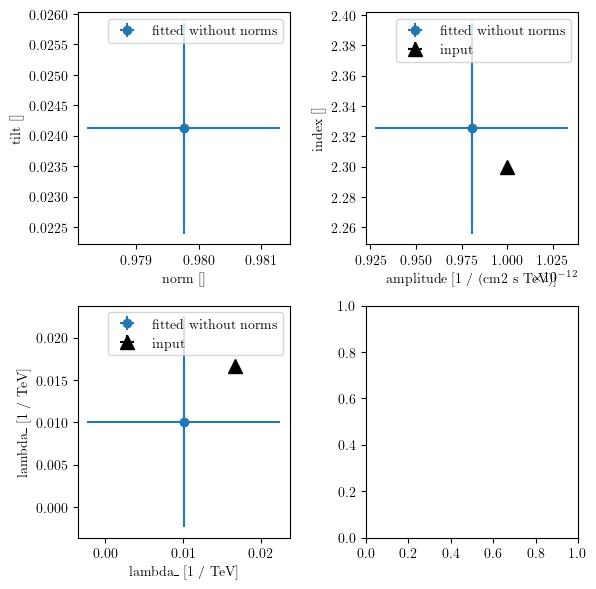

In [16]:
models_list = [ dataset_asimov.models,dataset_input.models ]
labels = [ 'fitted without norms', 'input']
fmts = ['o','^', '*']
colors = ['tab:blue', 'black', 'tab:green']
pars =  pars = [('norm', 'tilt'),('amplitude', 'index'),
               ('lambda_', 'lambda_')]
fig = plot_source_par(0, pars)



## BKG Energybin wise systematic

In [17]:
dataset_asimov_N = dataset_asimov.copy()

In [18]:
energy = dataset_asimov_N.geoms['geom'].axes[0].center
l = len(energy)
norms = Parameters([Parameter ("norm"+str(i), value = 0, is_penalised = True, 
                               frozen = False) for i in range(l)])
for n in norms[~emask]:
    print(n.name)
    n.frozen = True
piece = PiecewiseNormSpectralModel(energy = energy,
                          norms = norms,
                                  interp="lin")

import operator
bkg_spectral = CompoundNormSpectralModel(model1 = piece, 
                                        model2 = PowerLawNormSpectralModel(),
                                        operator= operator.add)

bkg_sys = FoVBackgroundModel(spectral_model = bkg_spectral,
                            dataset_name= dataset_asimov_N.name)
bkg_sys.parameters['norm'].frozen = False
bkg_sys.parameters['tilt'].frozen = False
dataset_asimov_N.models = Models([source_model.copy(), bkg_sys])

norm0
norm1
norm2
norm3


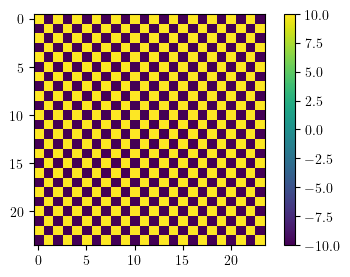

In [19]:
from numpy.linalg import inv
ainv = inv(cov)
dataset_asimov_N.penalising_invcovmatrix = ainv

fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(ainv, vmin = -10, vmax = 10)
fig.colorbar(pos, ax=ax1)

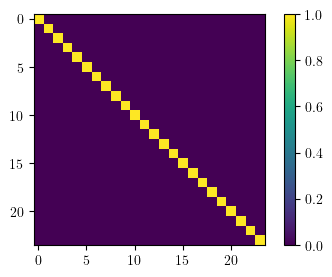

In [20]:
from numpy.linalg import inv

fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(np.matmul(cov,ainv), vmin = 0, vmax = 1)
fig.colorbar(pos, ax=ax1)

In [21]:
print(dataset_asimov_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : FHQuAjzH
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.017   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : ZIkIuJw8-bkg
  Datasets names            : ['ZIkIuJw8']
  Spectral model type       : CompoundNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm

In [22]:
%%time
fit_sys = Fit()
fit_sys.run(dataset_asimov_N)

CPU times: user 2min 48s, sys: 1min 9s, total: 3min 58s
Wall time: 3min 58s


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization failed.
	nfev       : 3529
	total stat : 841293.27

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

[ 0.          0.          0.          0.          0.00313982 -0.00191482
 -0.02201316 -0.04612709 -0.06678415 -0.0799339  -0.07493264 -0.05121437
 -0.0232257  -0.00171936  0.0173852   0.04553125  0.07597688  0.07827272
  0.04562385  0.01883186  0.03042853  0.06300959  0.08440262  0.08517327]


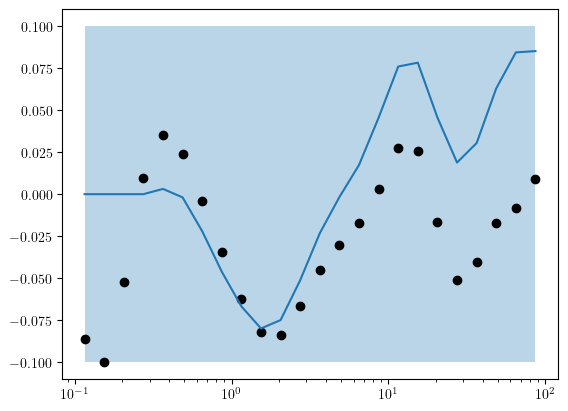

In [23]:
values_fitted = dataset_asimov_N.models[1].spectral_model.model1(energy)
print(values_fitted)
plt.plot(energy, values_fitted)
plt.fill_between(energy.value, sys_percentage/100,-sys_percentage/100,
                alpha = 0.3)
plt.scatter(energy.value, values, color = 'black')

plt.yscale("linear")
plt.xscale("log")

In [24]:
config = Dataset_load.load_config()
colors = config["colors"]["three"]
import ast

colors[1] = ast.literal_eval(colors[1])
colors[2] = ast.literal_eval(colors[2])
colors[3] = ast.literal_eval(colors[3])



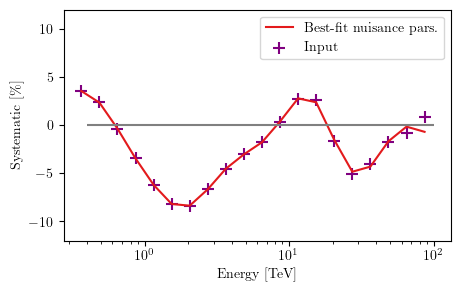

In [25]:
fig, ax = plt.subplots(figsize = (5,3))

values_fitted = dataset_asimov_N.models[1].spectral_model(energy)
plt.plot(energy.value[emask], 100 * values_fitted[emask]-100, color = colors[1],
        label = "Best-fit nuisance pars.")

#plt.fill_between(energy.value[emask], sys_percentage[emask],-sys_percentage[emask],
#                alpha = 0.1, color = 'tab:green')
plt.scatter(energy.value[emask], 100*values[emask], color = 'purple',
            marker = "+", s = 80,
           label = "Input")
plt.xscale('log')
plt.hlines(0, 0.4,100, color= 'grey')
plt.yscale("linear")
plt.ylim(-12,12)
plt.xlabel("Energy [TeV]")
plt.ylabel("Systematic [\%]")
plt.legend()
fig.savefig('plots/2_nui_sys_input.png', bbox_inches="tight")

(<WCSAxes: >, <Axes: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

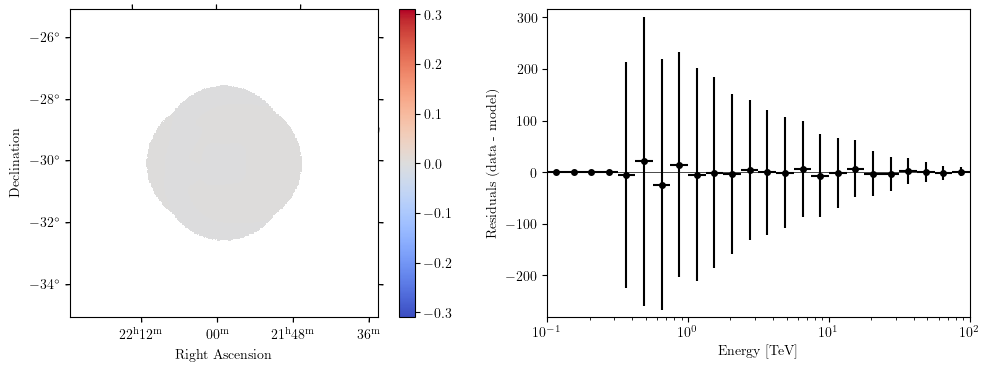

In [26]:

dataset_asimov_N.plot_residuals(kwargs_spatial={'vmax':0.31,
                                      'vmin':-0.31},
                      kwargs_spectral={'method' : 'diff'})

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1160: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1160: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


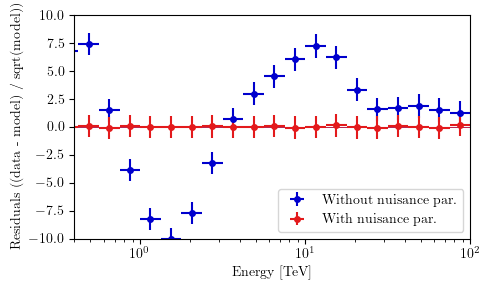

In [27]:
fig, ax = plt.subplots(figsize = (5,3))
ax = dataset_asimov.plot_residuals_spectral(method =  'diff/sqrt(model)',
                                            color = colors[0], 
                                    label = "Without nuisance par.")
dataset_asimov_N.plot_residuals_spectral(method =  'diff/sqrt(model)',
                                         color =colors[1],
                                             label = "With nuisance par.",
                                        )

#plt.fill_between(energy.value, sys_percentage[emask],-sys_percentage[emask],alpha = 0.3)
ax.legend()
ax.set_xlim(0.4,100)
ax.set_ylim(-10,10)

plt.tight_layout()
'''

ax2 = ax.twinx()
dataset_asimov_N.models[1].spectral_model.plot([1,100]*u.TeV, ax = ax2)
#ax2.fill_between(energy.value, 1+sys_percentage/100,1-sys_percentage/100,
#                alpha = 0.3)
ax2.scatter(energy.value, 1+values, color = 'black')
ax2.set_ylim(0.9, 1.1)
plt.yscale("linear")
'''

lim = ax.get_ylim()
ax.set_ylim(-np.max(np.abs(lim)), np.max(np.abs(lim)))
fig = plt.gcf()
fig.savefig('plots/2_spectracl_res_points_diff.png')

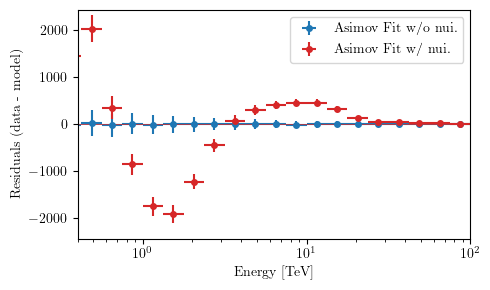

In [28]:
fig, ax = plt.subplots(figsize = (5,3))
ax = dataset_asimov_N.plot_residuals_spectral(method =  'diff', color = 'tab:blue',
                                             label = "Asimov Fit w/o nui.")
dataset_asimov.plot_residuals_spectral(method =  'diff', color = 'tab:red', ax = ax,
                                    label = "Asimov Fit w/ nui.")
#plt.fill_between(energy.value, sys_percentage[emask],-sys_percentage[emask],alpha = 0.3)
ax.legend()
ax.set_xlim(0.4,100)
plt.tight_layout()
'''
ax2 = ax.twinx()
dataset_asimov_N.models[1].spectral_model.plot([1,100]*u.TeV, ax = ax2)
#ax2.fill_between(energy.value, 1+sys_percentage/100,1-sys_percentage/100,
#                alpha = 0.3)
ax2.scatter(energy.value, 1+values, color = 'black')
ax2.set_ylim(0.9, 1.1)
plt.yscale("linear")
'''
lim = ax.get_ylim()
ax.set_ylim(-np.max(np.abs(lim)), np.max(np.abs(lim)))
fig = plt.gcf()
fig.savefig('plots/2_spectracl_res_points.png')

In [29]:
print(dataset_input.models)

DatasetModels

Component 0: SkyModel

  Name                      : oXLdAvKg
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.017   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : i-u5Q_ih-bkg
  Datasets names            : ['i-u5Q_ih']
  Spectral model type       : PiecewiseNormSpectralModel
  Spatial  model type       : 
  Parameters:
    nor

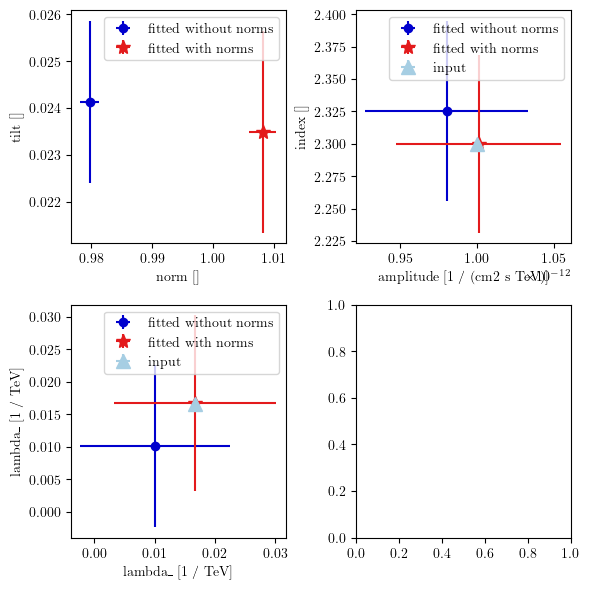

In [30]:
models_list = [ dataset_asimov.models, dataset_asimov_N.models , dataset_input.models]
labels = [ 'fitted without norms','fitted with norms', 'input']
fmts = ['o','*', '^', ]

pars =  pars = [('norm', 'tilt'),('amplitude', 'index'),
               ('lambda_', 'lambda_')]
ax = plot_source_par(0, pars)


## FLuxpoints

In [31]:
comput_fp = 1
if comput_fp :
    energy_edges = dataset_asimov.geoms["geom"].axes[0].edges[::2]
    esti = FluxPointsEstimator(energy_edges=energy_edges)
    fluxpoints = esti.run([dataset_asimov])
    fluxpoints.write(
        "data/fluxpoints/2_fluxpoints_asimov.fits", overwrite = True
    )
    Models([dataset_asimov.models[0]]).write(
        "data/fluxpoints/2_model_asimov.fits" , overwrite = True
    )
    
    fluxpoints_N = esti.run([dataset_asimov_N])
    fluxpoints_N.write(
        f"data/fluxpoints/2_fluxpoints_asimov_N.fits", overwrite= True,
    )
    Models([dataset_asimov_N.models[0]]).write(
        f"data/fluxpoints/2_model_asimov_N.fits", overwrite= True,
    )
    
    fp_asimov = FluxPointsDataset(data = fluxpoints, models = Models([dataset_asimov.models[0]]))
    fp_asimov_N = FluxPointsDataset(data = fluxpoints_N, models = Models([dataset_asimov_N.models[0]]))
    
else:
    fp_asimov = FluxPointsDataset(data = FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov.fits"),
                                 models = Models.read("data/fluxpoints/2_model_asimov.fits"))
    fp_asimov_N = FluxPointsDataset(data = FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov_N.fits"),
                                 models = Models.read("data/fluxpoints/2_model_asimov_N.fits"))


0.10000000000000002 TeV 0.1778279410038923 TeV
norm 1.0 0

0.1778279410038923 TeV 0.316227766016838 TeV
norm 1.0 0

0.316227766016838 TeV 0.5623413251903491 TeV
norm 1.095293867720732 0.14211477309862466

0.5623413251903491 TeV 1.0 TeV
norm 0.9951529653205053 0.09314843362524582

1.0 TeV 1.7782794100389232 TeV
norm 0.9381338675189833 0.09267745079980096

1.7782794100389232 TeV 3.1622776601683795 TeV
norm 0.9664117085184649 0.11545999542598843

3.1622776601683795 TeV 5.623413251903489 TeV
norm 1.0463806513615825 0.15675447331151557

5.623413251903489 TeV 10.000000000000002 TeV
norm 1.092000544917477 0.21834859633894635

10.000000000000002 TeV 17.78279410038923 TeV
norm 1.0979319345309597 0.3053553636400088

17.78279410038923 TeV 31.62277660168379 TeV
norm 0.9902396088628811 0.4133428854300784

31.62277660168379 TeV 56.234132519034915 TeV
norm 0.8940806113287497 0.6156524435808601

56.234132519034915 TeV 100.00000000000004 TeV
norm 0.7592352507158133 1.0046850174993722

0.10000000000000

In [32]:
import seaborn as sns


alpha_nui = 0.99
alpha_st = 0.99
legendsscatter = ["Asimov w/o nui.", "Asimov with nui."]
legends = ["", ""]

alpha_rnd = 0.2
alpha_rnd_nui = 0.2

nbins = 20

In [33]:
def plot_asimov_spectrum(fig, ax):
    model = dataset_asimov_N.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[1],
        label="Asimov Fit with nui.",
        linestyle="solid",
    )

    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[3],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[0],
        linestyle="dashed",
        label="Asimov Fit w/0 nui.",
    )
    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[2],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0]
    dataset_input.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color="black",
        label="Input",
        linestyle="dotted",
    )

    ax.legend(loc="lower left")
    ax.set_xlim(0.3, 100)
    ax.set_ylim(1e-14, 2e-12)

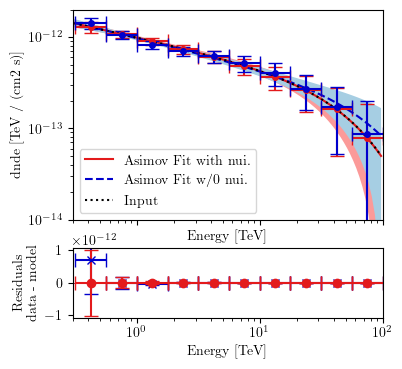

In [34]:
fp_asimov = FluxPointsDataset(
    data=FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov.fits"),
    models=Models.read("data/fluxpoints/2_model_asimov.fits"),
)
fp_asimov_N = FluxPointsDataset(
    data=FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov_N.fits"),
    models=Models.read("data/fluxpoints/2_model_asimov_N.fits"),
)

def compute_precision(N):
    Z = 1.645
    return Z / np.sqrt(N)


energy_power = 2
fig, axs = plt.subplots(2, 1, figsize=(4, 4), sharex=True, gridspec_kw={"height_ratios": [3, 1]},)
plot_asimov_spectrum(fig, axs[0])
fp_asimov_N.data.plot(energy_power=2, color=colors[1], ax=axs[0], capsize = 5)
fp_asimov.data.plot(energy_power=2, color=colors[0], ax=axs[0], capsize = 5)


fp_asimov.plot_residuals(ax =axs[1], color = colors[0], capsize = 5, marker = 'x')
fp_asimov_N.plot_residuals(ax =axs[1], color = colors[1],  capsize = 5, marker = 'o')

axs[0].set_xlim(0.3, 100)
fig.savefig("plots/2_fluxpoints_spectrum.pdf", bbox_inches="tight")
fig.savefig("plots/2_fluxpoints_spectrum.png", bbox_inches="tight")

In [35]:
for p in ['amplitude', 'index', 'lambda_']:
    print(p)
    for i, d in enumerate([dataset_asimov, dataset_asimov_N, dataset_input]):
        pp = d.models[0].parameters[p]
        print(f"{labels[i]}")
        if p == 'lambda_':
            print(f"$1/{(1/pp.value):.3} \pm 1/{(pp.error/pp.value**2):.3}$")   
        if p == 'amplitude':
            print(f"${pp.value*1e12:.2} \pm {pp.error*1e12:.2}$")   
            
        else:
            print(f"${pp.value:.4} \pm {pp.error:.4}$")   
        
    print()

amplitude
fitted without norms
$0.98 \pm 0.053$
fitted with norms
$1.0 \pm 0.054$
input
$1.0 \pm 0.0$

index
fitted without norms
$2.325 \pm 0.06955$
fitted with norms
$2.3 \pm 0.06883$
input
$2.3 \pm 0.0$

lambda_
fitted without norms
$1/99.0 \pm 1/1.22e+02$
$0.0101 \pm 0.01242$
fitted with norms
$1/59.7 \pm 1/48.1$
$0.01676 \pm 0.0135$
input
$1/60.0 \pm 1/0.0$
$0.01667 \pm 0.0$

